# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns

from pathlib import Path
from matplotlib import pyplot as plt

# 1.0 Load data

In [2]:
path = str(Path.cwd().parents[0] / "data" / "raw")
path = path + '/' + 'df_raw.csv'

df = pd.read_csv(path)

# 2.0 Data Description

In [3]:
df.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## 2.1 Data Dimensions

In [4]:
df_dim = df.copy()

In [5]:
df_dim.shape

(381109, 12)

In [6]:
df_dim.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [7]:
df_dim.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 2.2 Change Types

In [8]:
# region_code to int64
df_dim['region_code'] = df_dim['region_code'].astype('int64')

# policy_sales_channel to int64
df_dim['policy_sales_channel'] = df_dim['policy_sales_channel'].astype('int64')

# vehicle_age:
#   <1 : 'New'
#   1-2 : 'Average'
#   >2 : 'Used'
# WARNING: dont run this segment more than once, or all rows in the column 'vehicle_age' will be = 'Used' 
df_dim['vehicle_age'] = df_dim['vehicle_age'].apply(lambda x: 'New' if x == '< 1 Year' else
                                            'Average' if x == '1-2 Year' else
                                            'Used')

# WARNING: dont run this segment more than once, or all rows in the columns will have the value after 'else' (No) 
df_dim['driving_license'] = df_dim['driving_license'].apply(lambda x: 'Yes' if x == 1 else 'No')
df_dim['previously_insured'] = df_dim['previously_insured'].apply(lambda x: 'Yes' if x == 1 else 'No')

## 2.3 Check and Fill NAs

In [9]:
# dropna() function removes rows (by default) which at least one NA value
# So, if at least one row was removed, then we have at least one NA value on this dataset
if (df_dim.dropna().shape == df_dim.shape):
    print('Not a single NA on this dataset')

else:
    print('There is at least one NA value on this dataset')

Not a single NA on this dataset


## 2.4 Descriptive Statistics

In [10]:
df_desc = df_dim.copy()

### 2.4.1 Separating Numerical and Categorical Attributes

In [11]:
# numerical attributes
aux = df_desc.applymap(np.isreal) # All numeric values will be set as True. Non-numeric will be set as 'False'
num_att = df_desc[aux] # copy all numeric values. Non-numeric will be set as 'NaN'
num_att = num_att.dropna(axis=1) # drop entire column if it contains any NA value

# categorical attributes
cat_att = df_desc[~ aux] # copy all non-numeric values (see the negation ~ signal). Numeric will be set as 'NaN'
cat_att = cat_att.dropna(axis=1) # drop entire column if it contains any NA value

### 2.4.2 Numerical Attributes Metrics

In [12]:
num_att = num_att.drop(columns = 'id') # it is not useful to know metrics of this column

# central tendency
mean = pd.DataFrame(num_att.apply(np.mean)).T
median = pd.DataFrame(num_att.apply(np.median)).T

# dispersion metrics
std = pd.DataFrame(num_att.apply(np.std)).T
min_ = pd.DataFrame(num_att.min()).T
max_ = pd.DataFrame(num_att.max()).T
range = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(num_att.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

# concatenate
metrics = pd.concat([mean, median, std, min_, max_, range, skew, kurtosis]).T.reset_index()
metrics.columns = ['attributes', 'avg', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']

In [13]:
metrics

,attributes,avg,median,std,min,max,range,skew,kurtosis
0,age,38.822584,36.0,15.511591,20.0,85.0,65.0,0.672539,-0.565655
1,region_code,26.388807,28.0,13.229871,0.0,52.0,52.0,-0.115266,-0.867857
2,policy_sales_channel,112.034295,133.0,54.203924,1.0,163.0,162.0,-0.900008,-0.970810
3,annual_premium,30564.389581,31669.0,17213.132474,2630.0,540165.0,537535.0,1.766087,34.004569
4,vintage,154.347397,154.0,83.671194,10.0,299.0,289.0,0.003030,-1.200688
5,response,0.122563,0.0,0.327935,0.0,1.0,1.0,2.301906,3.298788


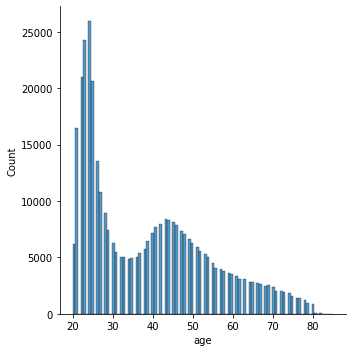

In [14]:
sns.displot(num_att['age']);

### 2.4.3 Categorical Attributes

In [15]:
# how many unique categories
cat_att.apply(lambda x: x.unique().shape[0])

gender                2
driving_license       2
vehicle_age           3
vehicle_damage        2
previously_insured    2
dtype: int64

#### 2.4.3.1 Response by Gender
How many males and females responded Yes or No?

In [81]:
# splitting dataset by gender and response then counting unique ids within each group
response_count = df_desc[['id', 'gender', 'response']].groupby(['gender', 'response']).count()
response_count.columns = ['count']
response_count = response_count.reset_index(level=['gender', 'response']) # transform gender and response index keys into columns

# replaces 1/0 values by Yes/No
response_count['response'] = response_count['response'].apply(lambda x: 'Yes' if x == 1 else 'No')

# calculates how many responses as percentage from total responses of each gender
response_count['pct%'] = 100 * response_count['count'] / (response_count.groupby('gender')['count'].transform('sum'))

response_count

,gender,response,count,pct%
0,Female,No,156835,89.609759
1,Female,Yes,18185,10.390241
2,Male,No,177564,86.158893
3,Male,Yes,28525,13.841107


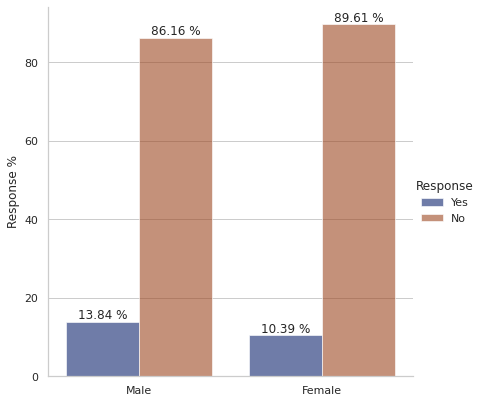

In [118]:
# draw a nested barplot by response and gender
g = sns.catplot(
    data = response_count,
    kind = 'bar',
    x = 'gender',
    y = 'pct%',
    order = ['Male', 'Female'], # categories plot order
    hue = 'response',
    hue_order = ['Yes', 'No'], # bars plot order
    palette = 'dark',
    alpha = 0.6,
    height = 6
)

# set labels
g.set_axis_labels("", "Response %")
g.legend.set_title("Response")

# plot Y-axis values on top of each bar
ax = g.facet_axis(0,0)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f %%')